# MobileNet Grading of Diabetic Retinopathy in PyTorch

In [26]:
from __future__ import print_function, division

from torchvision import datasets, transforms, utils
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torch
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.



In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Rest': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

DATA_DIR = 'DB'
ds_splits = ['Test', 'Rest']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
# Sample loader will inclulde shuffling for the purpose of getting images of various classes
sample_loader = torch.utils.data.DataLoader(image_datasets['Test'], batch_size=32,
                                        shuffle=True, num_workers=4)

# Test and Rest loader will be used to compute performance metrics such as confusion matrix and separating the suspected buggy images
test_dataloader = torch.utils.data.DataLoader(image_datasets['Test'], batch_size=32,
                                        shuffle=False, num_workers=4)

rest_dataloader = torch.utils.data.DataLoader(image_datasets['Rest'], batch_size=32,
                                        shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['Test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few testing images



In [47]:
def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

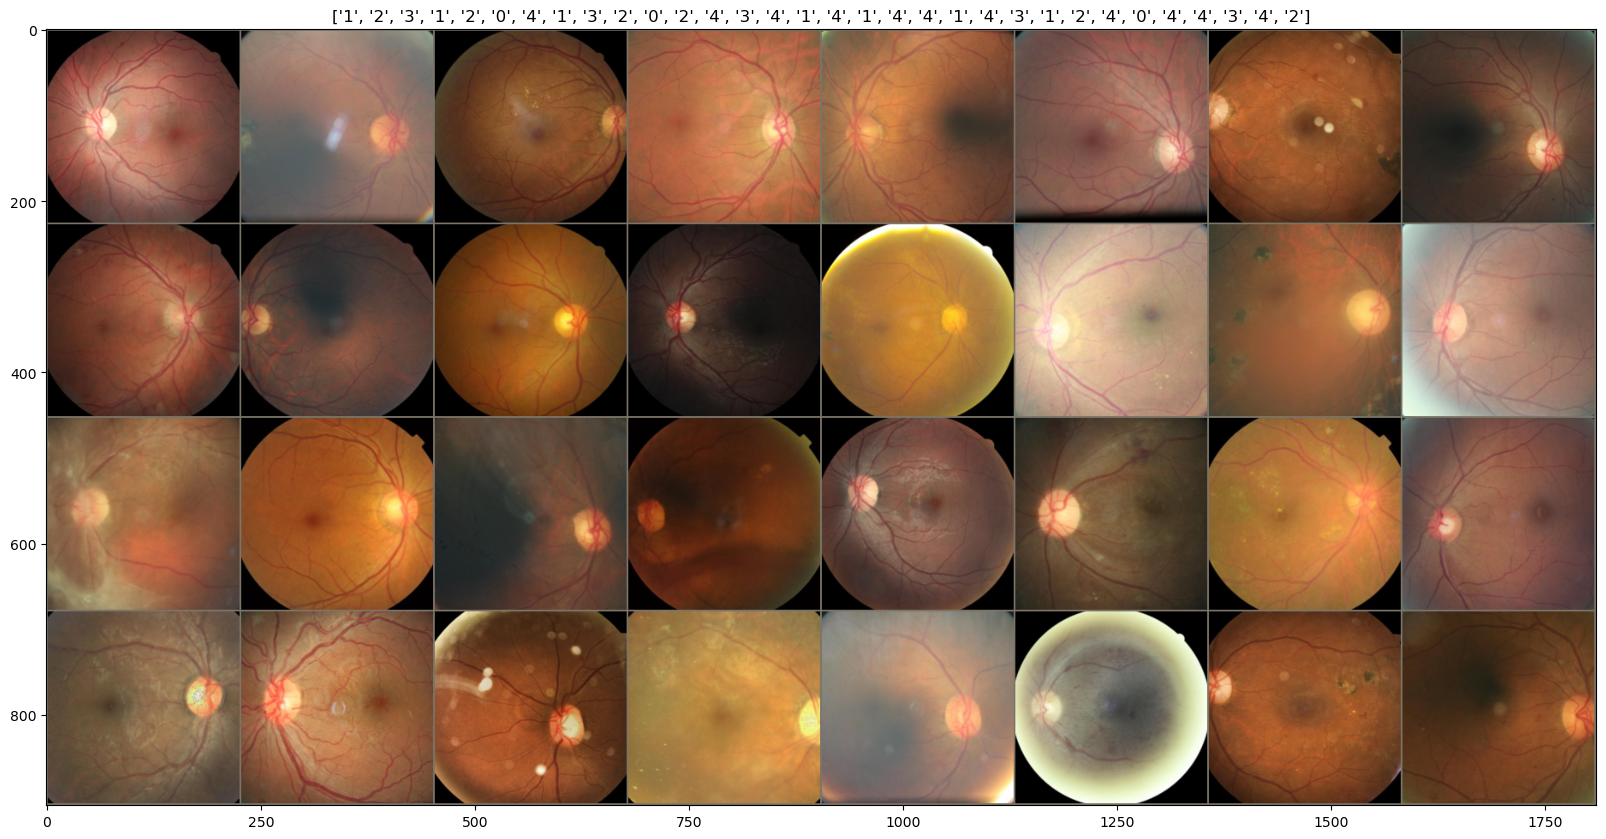

In [48]:
# Get a batch of training data
inputs, classes = next(iter(sample_loader))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))

### Visualizing the model predictions

Generic function to display predictions for a few images




In [49]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## initializing the convnet

Load a pretrained model and reset final fully connected layer.




In [22]:
FILENAME = 'MobileNetV3_Grading_23_Feb_23_17_04'
PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])

model_ft = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load(PATH))
model_ft.eval()

display(model_ft)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Train and evaluate




<Figure size 640x480 with 0 Axes>

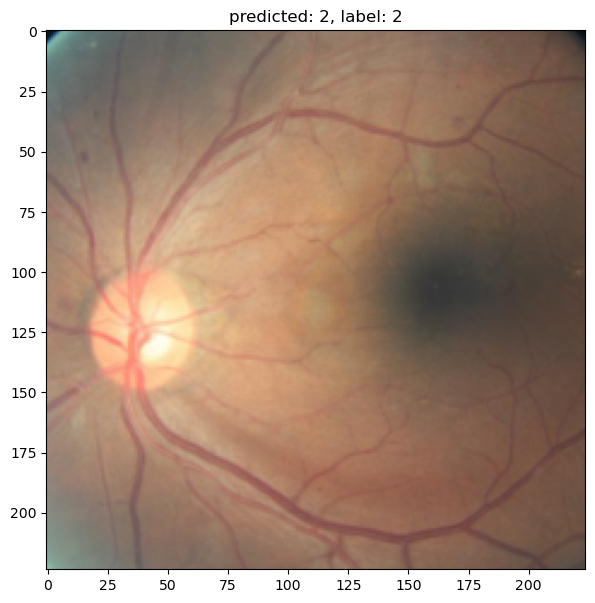

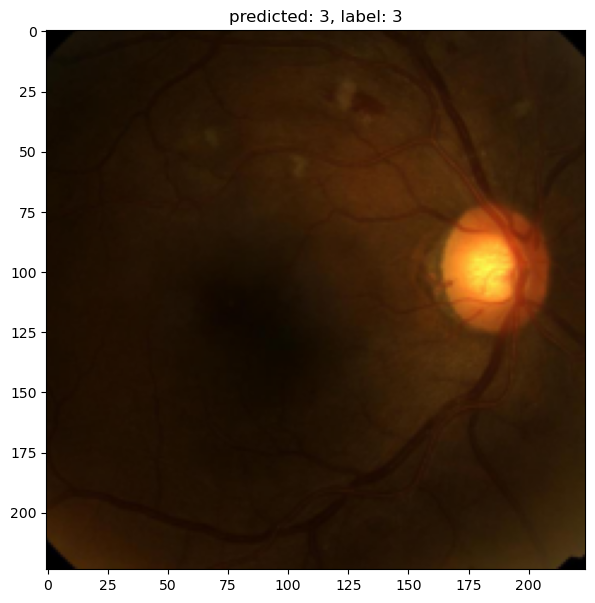

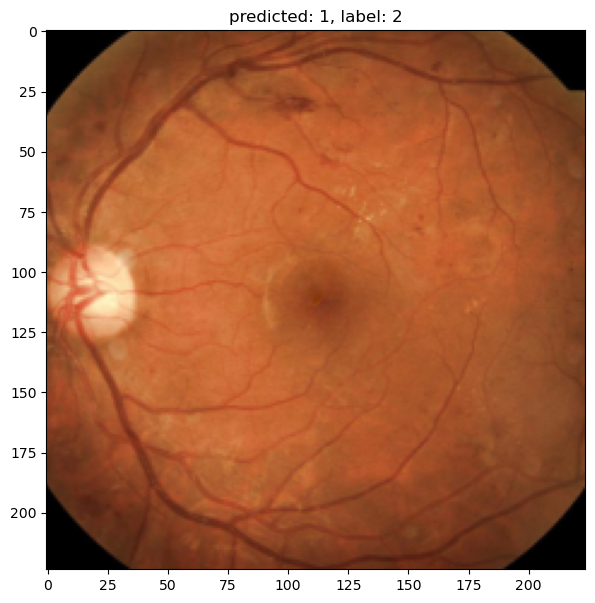

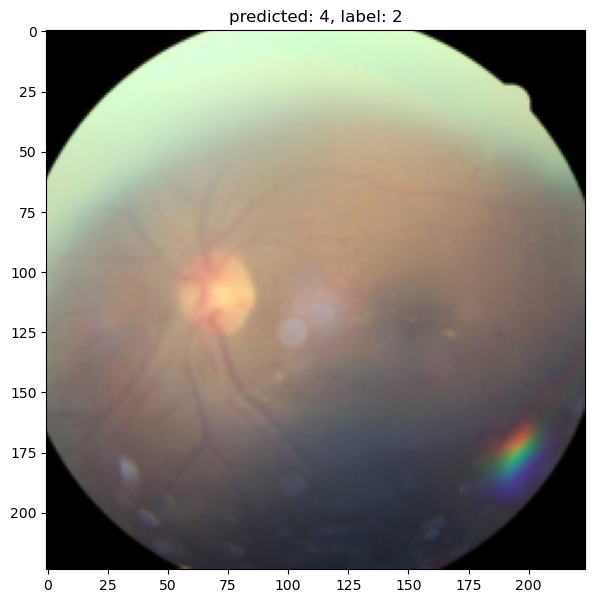

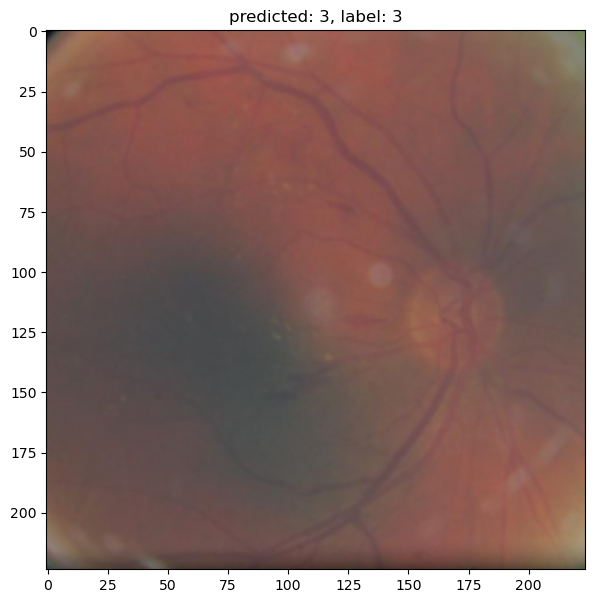

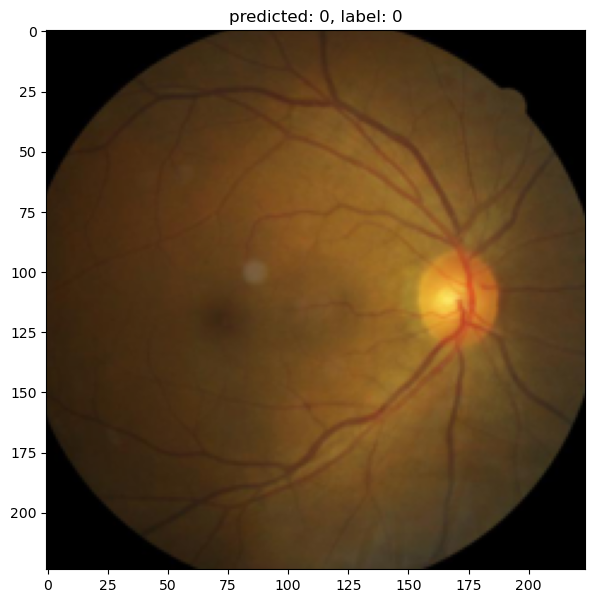

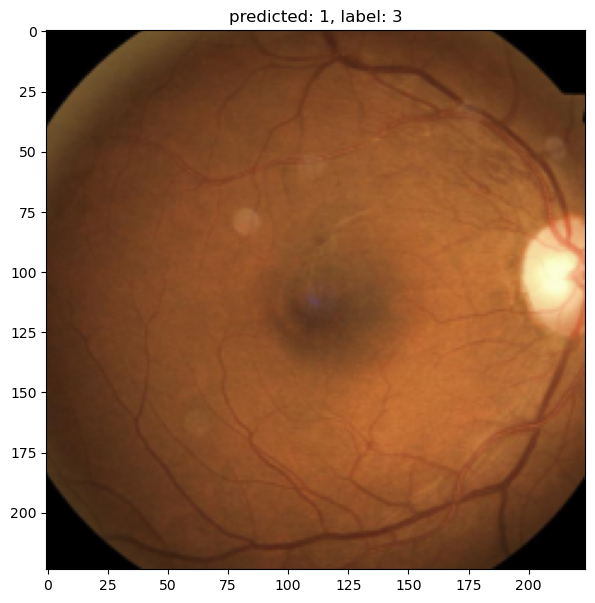

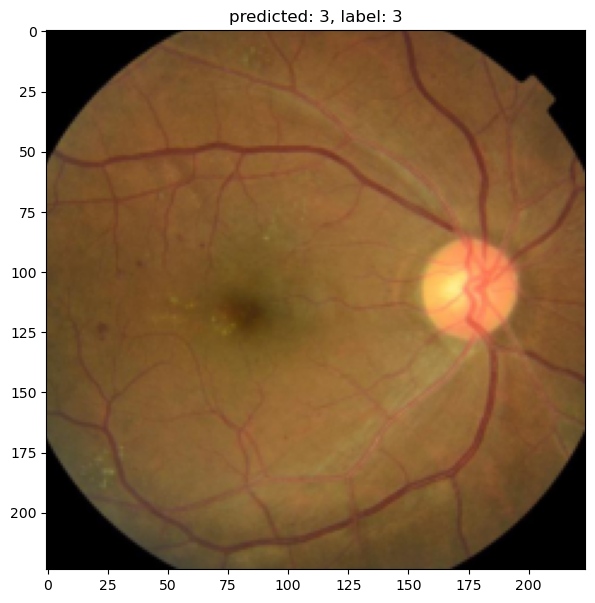

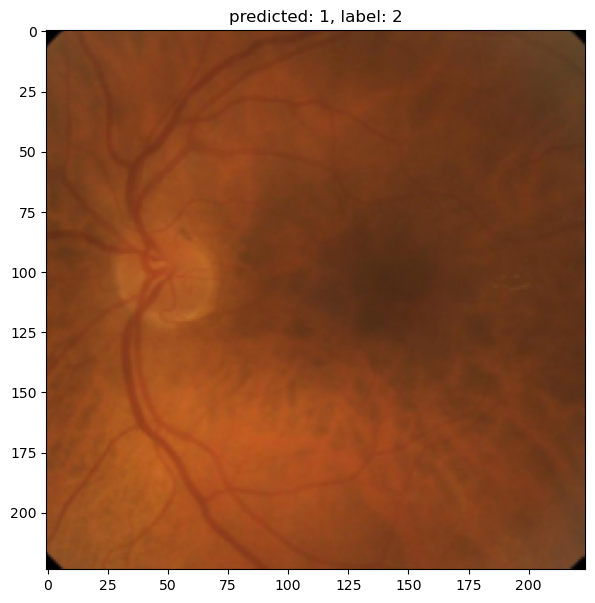

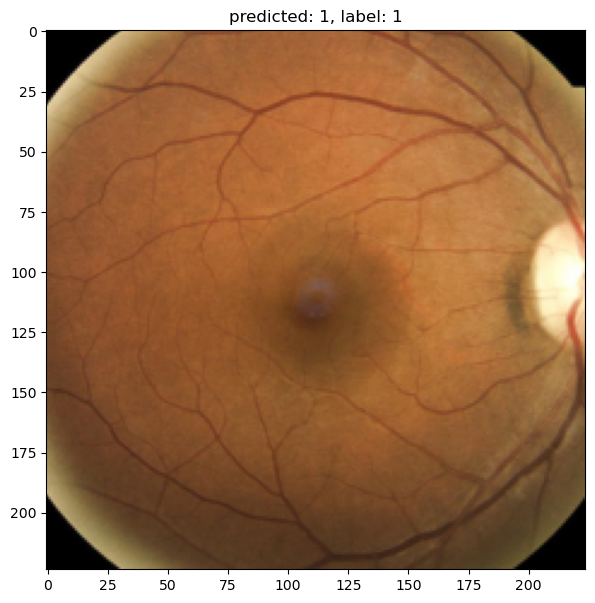

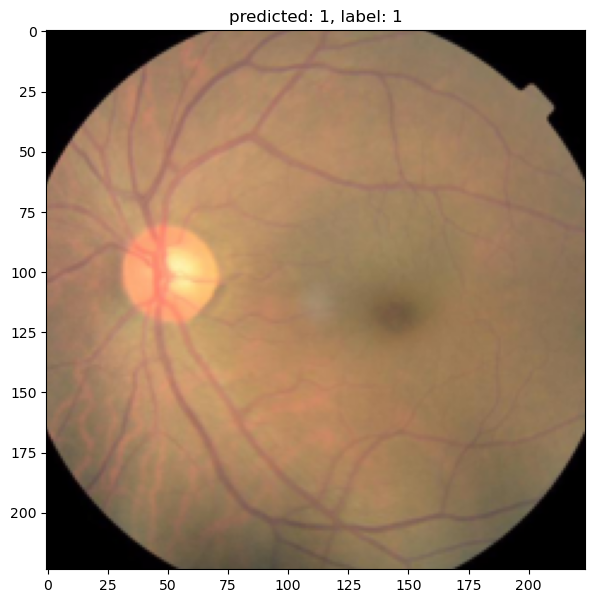

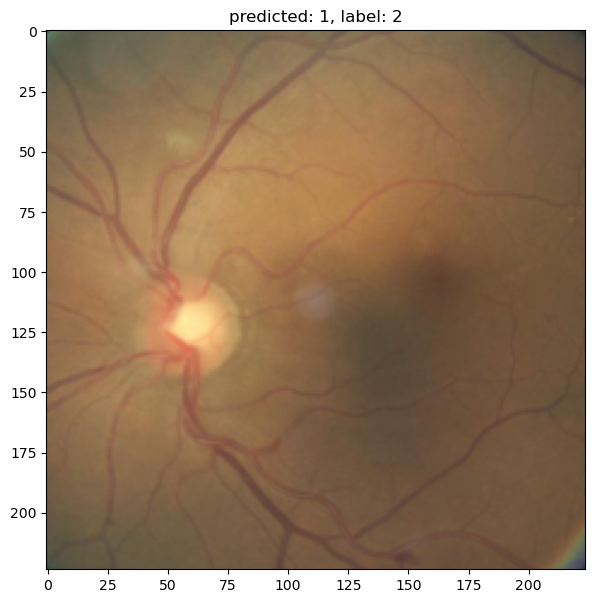

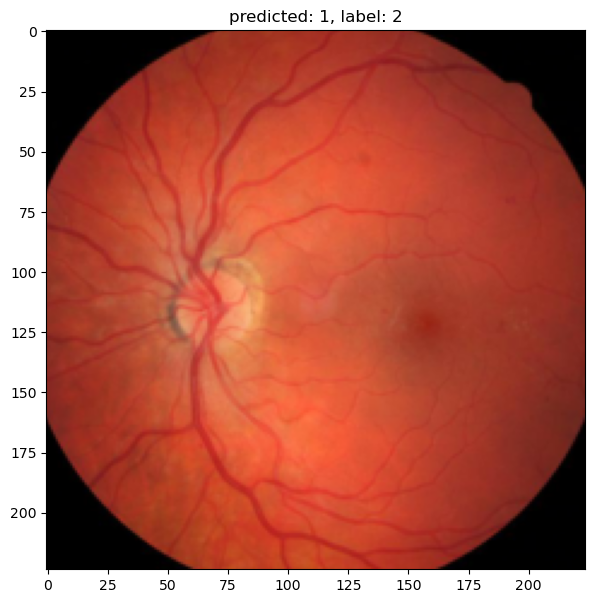

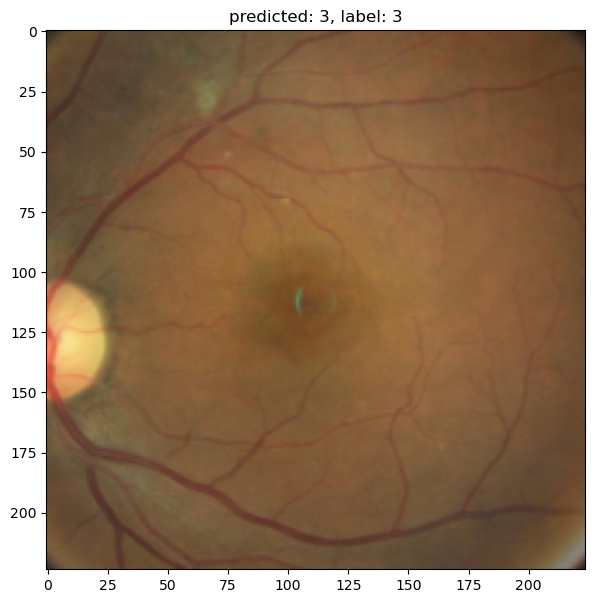

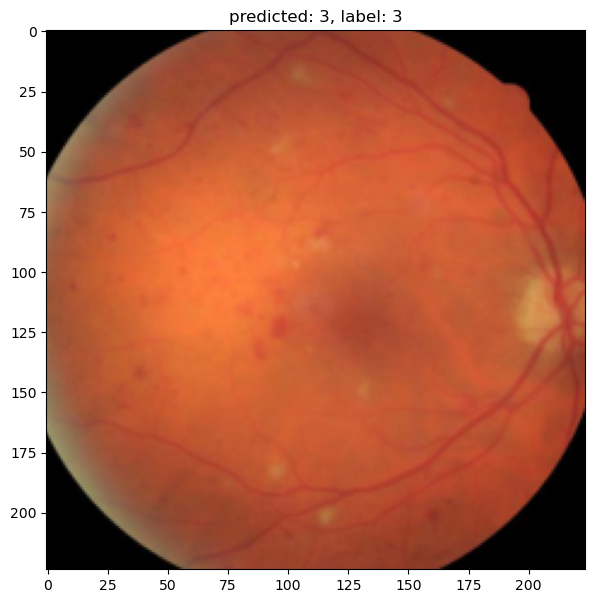

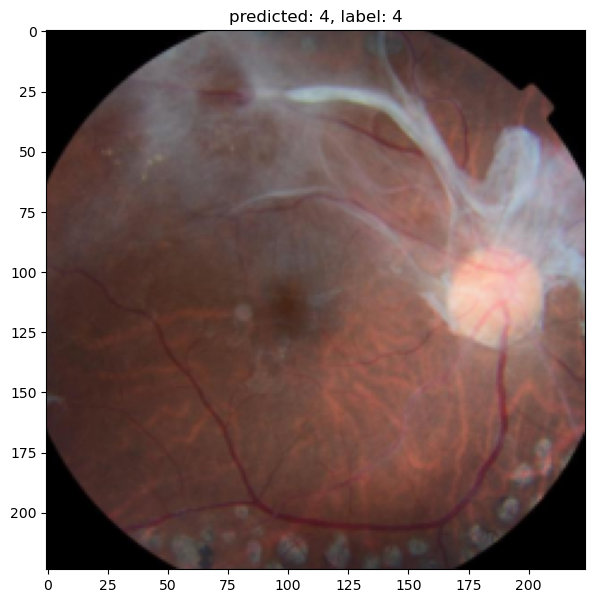

In [52]:
visualize_model(model_ft, 16)

In [6]:
y_true = [[],[]]
y_pred = [[],[]]
paths = [[],[]]
# iterate over test data
print("[INFO] Iterating predictions")

model_ft.eval()

loaders = [
        test_dataloader, 
        rest_dataloader
]

for i, dl in enumerate(loaders):
        paths[i] = np.array([p for p, _ in dl.dataset.imgs])
        print(f"Processing set {i+1}")
        for inputs, labels in dl:
                output = model_ft(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred[i].extend(output) # Save Prediction
                
                labels = labels.data.cpu().numpy()
                y_true[i].extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")

[INFO] Iterating predictions
Processing set 1
Processing set 2
[INFO] Finished iterating predictions


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

print(f"Mean Squared Error:{mse}")

[INFO] Building Matrix


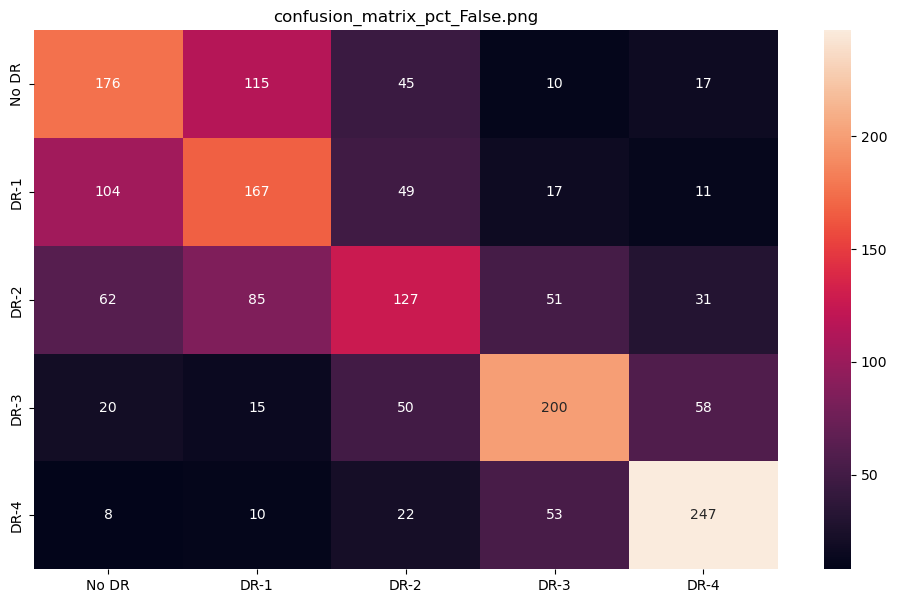

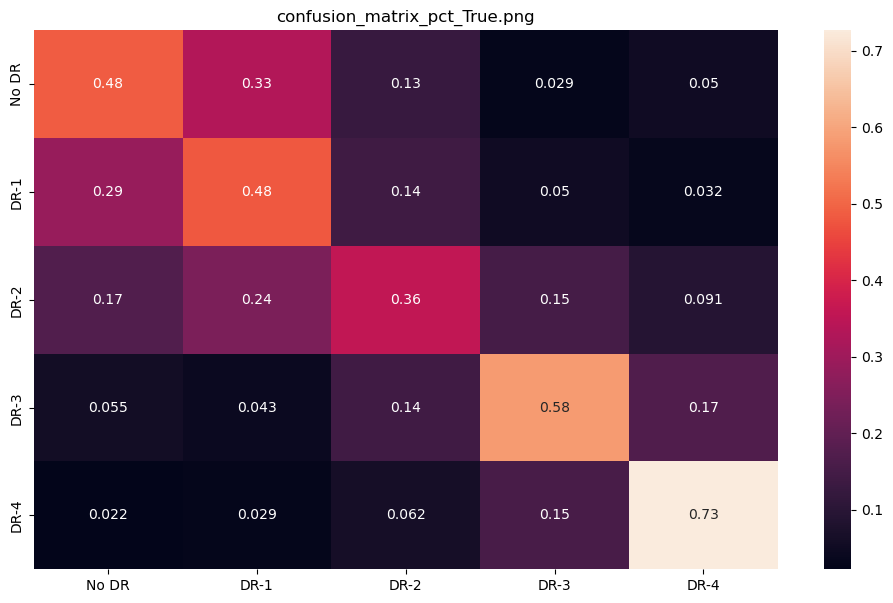

In [7]:
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'DR-1', 'DR-2', 'DR-3', 'DR-4')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix

cf_matrix = confusion_matrix(y_true[0], y_pred[0])
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        
        if pct:
                sn.heatmap(df_cm, annot=True)
        else:
                sn.heatmap(df_cm, annot=True, fmt='g')
        title = f'confusion_matrix_pct_{pct}.png'

        cm_path = os.path.sep.join([OUTPATH, title])
        plt.title(title)
        plt.savefig(cm_path)
        plt.show()

In [8]:
error_imgs = []
expected_error_imgs = []
correct_imgs = []
l_pred = [np.array(y) for y in y_pred]
l_true = [np.array(y) for y in y_true]

for trl, prl, pathlist in zip(l_pred,l_true, paths):

    diff = prl-trl

    error_imgs.extend(list(pathlist[(diff <= -2) | (diff >= 2)]))
    expected_error_imgs.extend(list(pathlist[(diff > -1) | (diff < 1)]))
    correct_imgs.extend(list(pathlist[diff == 0]))

In [9]:
from shutil import copy
base_error_paths = ['error_imgs', 'expected-error', 'correct']

for dir in base_error_paths:
    if os.path.exists(dir):
        !rm -r {dir}

    os.mkdir(dir)

    for img_path in error_imgs:
        unpacked = img_path.split(os.path.sep)[2:]
        folder = os.path.sep.join([dir, unpacked[0]])
        dest = os.path.sep.join([folder, unpacked[1]])

        if not os.path.exists(folder):
            os.mkdir(folder)
        copy(img_path, dest)